In [121]:

import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import patheffects as pe
from scipy.stats import multivariate_normal as mvn
from scipy.sparse import identity
#from autograd import grad

from matplotlib.collections import LineCollection

## Test Functions

In [122]:

def rastrigin(theta):
    n = len(theta)
    A = 10
    loss = A*n
    for i in range(n):
        loss += theta[i]**2 - A*np.cos(2*np.pi*theta[i])
    return loss

def drastrigin(theta):
    n = len(theta)
    A = 10
    grad = np.zeros((n,))
    for i in range(n):
        grad[i] = 2*theta[i] + 2*A*np.pi*np.sin(2*np.pi*theta[i])
    return grad


def stybtang(theta):
    n = len(theta)
    loss = 0
    for i in range(n):
        loss += (theta[i]**4 - 16*(theta[i]**2) + 5*theta[i])/2
    return loss

def dstybtang(theta):
    n = len(theta)
    grad = np.zeros((n,))
    for i in range(n):
        grad[i] = (4*(theta[i]**3) - 32*theta[i] + 5)/2
    return grad


def levy(theta):
    n = len(theta)
    w = np.zeros_like(theta)
    for i in range(n):
        w[i] = 1 + (theta[i] - 1)/4

    loss = (np.sin(np.pi*w[0]))**2 + (w[-1] - 1)**2 * (1 + (np.sin(2*np.pi*w[-1]))**2)
    for i in range(n-1):
        loss += (w[i] - 1)**2 * (1 + 10*(np.sin(np.pi*w[i] + 1))**2)
    
    return loss

def dlevy(theta):
    n = len(theta)
    w = np.zeros_like(theta)
    dw = np.zeros_like(theta)
    for i in range(n):
        w[i] = 1 + (theta[i] - 1)/4
        dw[i] = 1/4

    grad = np.zeros_like(theta)
    grad[0] = 2*np.pi*np.sin(np.pi*w[0])*np.cos(np.pi*w[0])*dw[0]
    grad[-1] = 2*(w[-1] - 1)*((1 + (np.sin(2*np.pi*w[-1]))**2) + 2*np.pi*(w[-1] - 1)*np.sin(2*np.pi*w[-1])*np.cos(2*np.pi*w[-1]))*dw[-1]
    for i in range(n-1):
        grad[i] += 2*(w[i] - 1)*(10*(np.sin(np.pi*w[i] + 1))**2 + 10*np.pi*(w[i] - 1)*np.sin(np.pi*w[i] + 1)*np.cos(np.pi*w[i] + 1) + 1)*dw[i]
    
    return grad

def ackley(theta):
    loss = -20*np.exp(-0.2*np.sqrt(0.5*(theta[0]**2 + theta[1]**2))) - np.exp(0.5*(np.cos(2*np.pi*theta[0]) + np.cos(2*np.pi*theta[1]))) + 20 + np.e
    return loss

def dackley(theta):
    grad = np.zeros_like(theta)
    grad[0] = (2*np.sqrt(2)*theta[0]*np.exp(-np.sqrt(theta[0]**2 + theta[1]**2)/(5*np.sqrt(2))))/np.sqrt(theta[0]**2 + theta[1]**2) + np.pi*np.sin(2*np.pi*theta[0])*np.exp(0.5*(np.cos(2*np.pi*theta[0]) + np.cos(2*np.pi*theta[1])))
    grad[1] = (2*np.sqrt(2)*theta[1]*np.exp(-np.sqrt(theta[1]**2 + theta[0]**2)/(5*np.sqrt(2))))/np.sqrt(theta[1]**2 + theta[0]**2) + np.pi*np.sin(2*np.pi*theta[1])*np.exp(0.5*(np.cos(2*np.pi*theta[1]) + np.cos(2*np.pi*theta[0])))
    return grad

def beale(theta):
    loss = (1.5 - theta[0] + theta[0]*theta[1])**2 + (2.25 - theta[0] + theta[0]*theta[1]*theta[1])**2 + (2.625 - theta[0] + theta[0]*theta[1]*theta[1]*theta[1])**2
    return loss

def dbeale(theta):
    grad = np.zeros_like(theta)
    grad[0] = 2*(1.5 - theta[0] + theta[0]*theta[1])*(-1 + theta[1]) + 2*(2.25 - theta[0] + theta[0]*theta[1]*theta[1])*(-1 + theta[1]*theta[1]) + 2*(2.625 - theta[0] + theta[0]*theta[1]*theta[1]*theta[1])*(-1 + theta[1]*theta[1]*theta[1])
    grad[1] = 2*(1.5 - theta[0] + theta[0]*theta[1])*theta[0] + 2*(2.25 - theta[0] + theta[0]*theta[1]*theta[1])*(2*theta[0]*theta[1]) + 2*(2.625 - theta[0] + theta[0]*theta[1]*theta[1]*theta[1])*(3*theta[0]*theta[1]*theta[1])
    return grad

def keanebump(theta):
    n = len(theta)
    cos2 = np.cos(theta) ** 2
    num2 = (np.sum( cos2**2 ) - 2 * np.prod( cos2 )) ** 2
    denom2 = np.arange( 1., n+1 ).dot( theta**2 )
    return num2 / denom2 + 1e-3*np.linalg.norm(theta)

def saddle(theta):
    a = 0.02
    s = 0.5
    min1 = 2*np.ones_like(theta)
    min2 = -min1
    return s*a*np.linalg.norm(theta - min1)**2 + (1-s)*a*np.linalg.norm(theta - min2)**2 - s*np.exp(-np.linalg.norm(theta - min1)**2/2) - (1-s)*np.exp(-np.linalg.norm(theta - min2)**2/2)

def dsaddle(theta):
    a = 0.02
    s = 0.5
    min1 = 2*np.ones_like(theta)
    min2 = -min1
    grad = np.zeros_like(theta)
    for i in range(len(theta)):
        grad[i] = s*a*2*(theta[i] - min1[i]) + (1-s)*a*2*(theta[i] - min2[i]) + s*np.exp(-np.linalg.norm(theta - min1)**2)*(theta[i] - min1[i]) + (1-s)*np.exp(-np.linalg.norm(theta - min2)**2)*(theta[i] - min2[i])
    return grad

def saddle2(theta):
    return (np.prod(theta) - 1)**2

def dsaddle2(theta):
    n = len(theta)
    grad = np.zeros_like(theta)
    for i in range(n):
        grad[i] = 2*(np.prod(theta) - 1)*np.prod(np.delete(theta, i))
    return grad

def saddle2_hessian_trace(theta):
    n = len(theta)
    hessian_diag = np.zeros((n,))
    for i in range(n):
        hessian_diag[i] = 2*np.square(np.prod(np.delete(theta, i)))
    return np.sum(hessian_diag)

def linear(theta):
    a = 0.01
    return np.sum(theta) + a*np.sum(np.square(theta))

def dlinear(theta):
    a = 0.01
    return np.ones_like(theta) + a*2*theta

# Opt Res Object

In [123]:

class OptRes():
    def __init__(self, ntheta: int, niter: int) -> None:
        self.niter = niter
        self.theta_hist = np.zeros((niter, ntheta))
        self.f_hist = np.zeros((niter,))
        self.g_hist = np.zeros((niter,))
        self.cont_hist = np.zeros((niter,))

    def fill(self, i: int, theta: np.ndarray, f: float, g: float, cont: float) -> None:
        self.theta_hist[i, :] = theta
        self.f_hist[i] = f
        self.g_hist[i] = g
        self.cont_hist[i] = cont

# Continuation Optimizer

In [124]:
def update_cont(f_samp: np.ndarray, df_samp: np.ndarray, eps_samp: np.ndarray, logcont: float, theta: np.ndarray) -> [float, float]:
    n = len(eps_samp[0])
    n_mc = len(f_samp)
    grad_logcont = 0.0
    a = 3e-3
    dtheta_samp = eps_samp*np.sqrt(np.exp(logcont))

    for j in range(n_mc):
        #grad_logcont += ((np.dot(eps_samp[j,:], eps_samp[j,:]) - n)/2)*f_samp[j]/n_mc
        grad_logcont += np.dot(df_samp[j,:], eps_samp[j,:])*np.sqrt(np.exp(logcont))/(2*n_mc)
        #grad_logcont += saddle2_hessian_trace(theta + dtheta_samp[j,:])*np.exp(logcont)/n_mc
    
    return min(logcont - a*grad_logcont, np.log(3)), grad_logcont

In [125]:
def gc_opt(f, df, theta0: np.ndarray, logcont0: float, nwarmup: int, niter: int, n_mc: int) -> OptRes:
    n = len(theta0)
    theta = theta0
    logcont = logcont0
    n_submc = n_mc

    a = 1e-3

    res = OptRes(n, niter)

    for i in range(niter):
        eps_samp = np.zeros((n_mc, n))
        dtheta_samp = np.zeros((n_mc, n))
        f_samp = np.zeros((n_mc,))
        df_samp = np.zeros((n_mc, n))

        for j in range(n_mc):
            eps_samp[j,:] = np.squeeze(np.random.randn(n, 1))
            dtheta_samp[j,:] = np.sqrt(np.exp(logcont))*eps_samp[j,:]
            f_samp[j] = f(theta + dtheta_samp[j,:])
            df_samp[j,:] = df(theta + dtheta_samp[j,:])

        if i > nwarmup:
            logcont, grad_logcont = update_cont(f_samp, df_samp, eps_samp, logcont, theta)
        
        if True:
            obj = np.mean(f_samp[:n_submc])
            grad = np.mean(df_samp[:n_submc], axis=0)

            res.fill(i, theta, f(theta), obj, np.exp(logcont))
            theta -= a*grad
    
    return res

# Main

[0.01852872 0.98384133]
1.0874732428775484


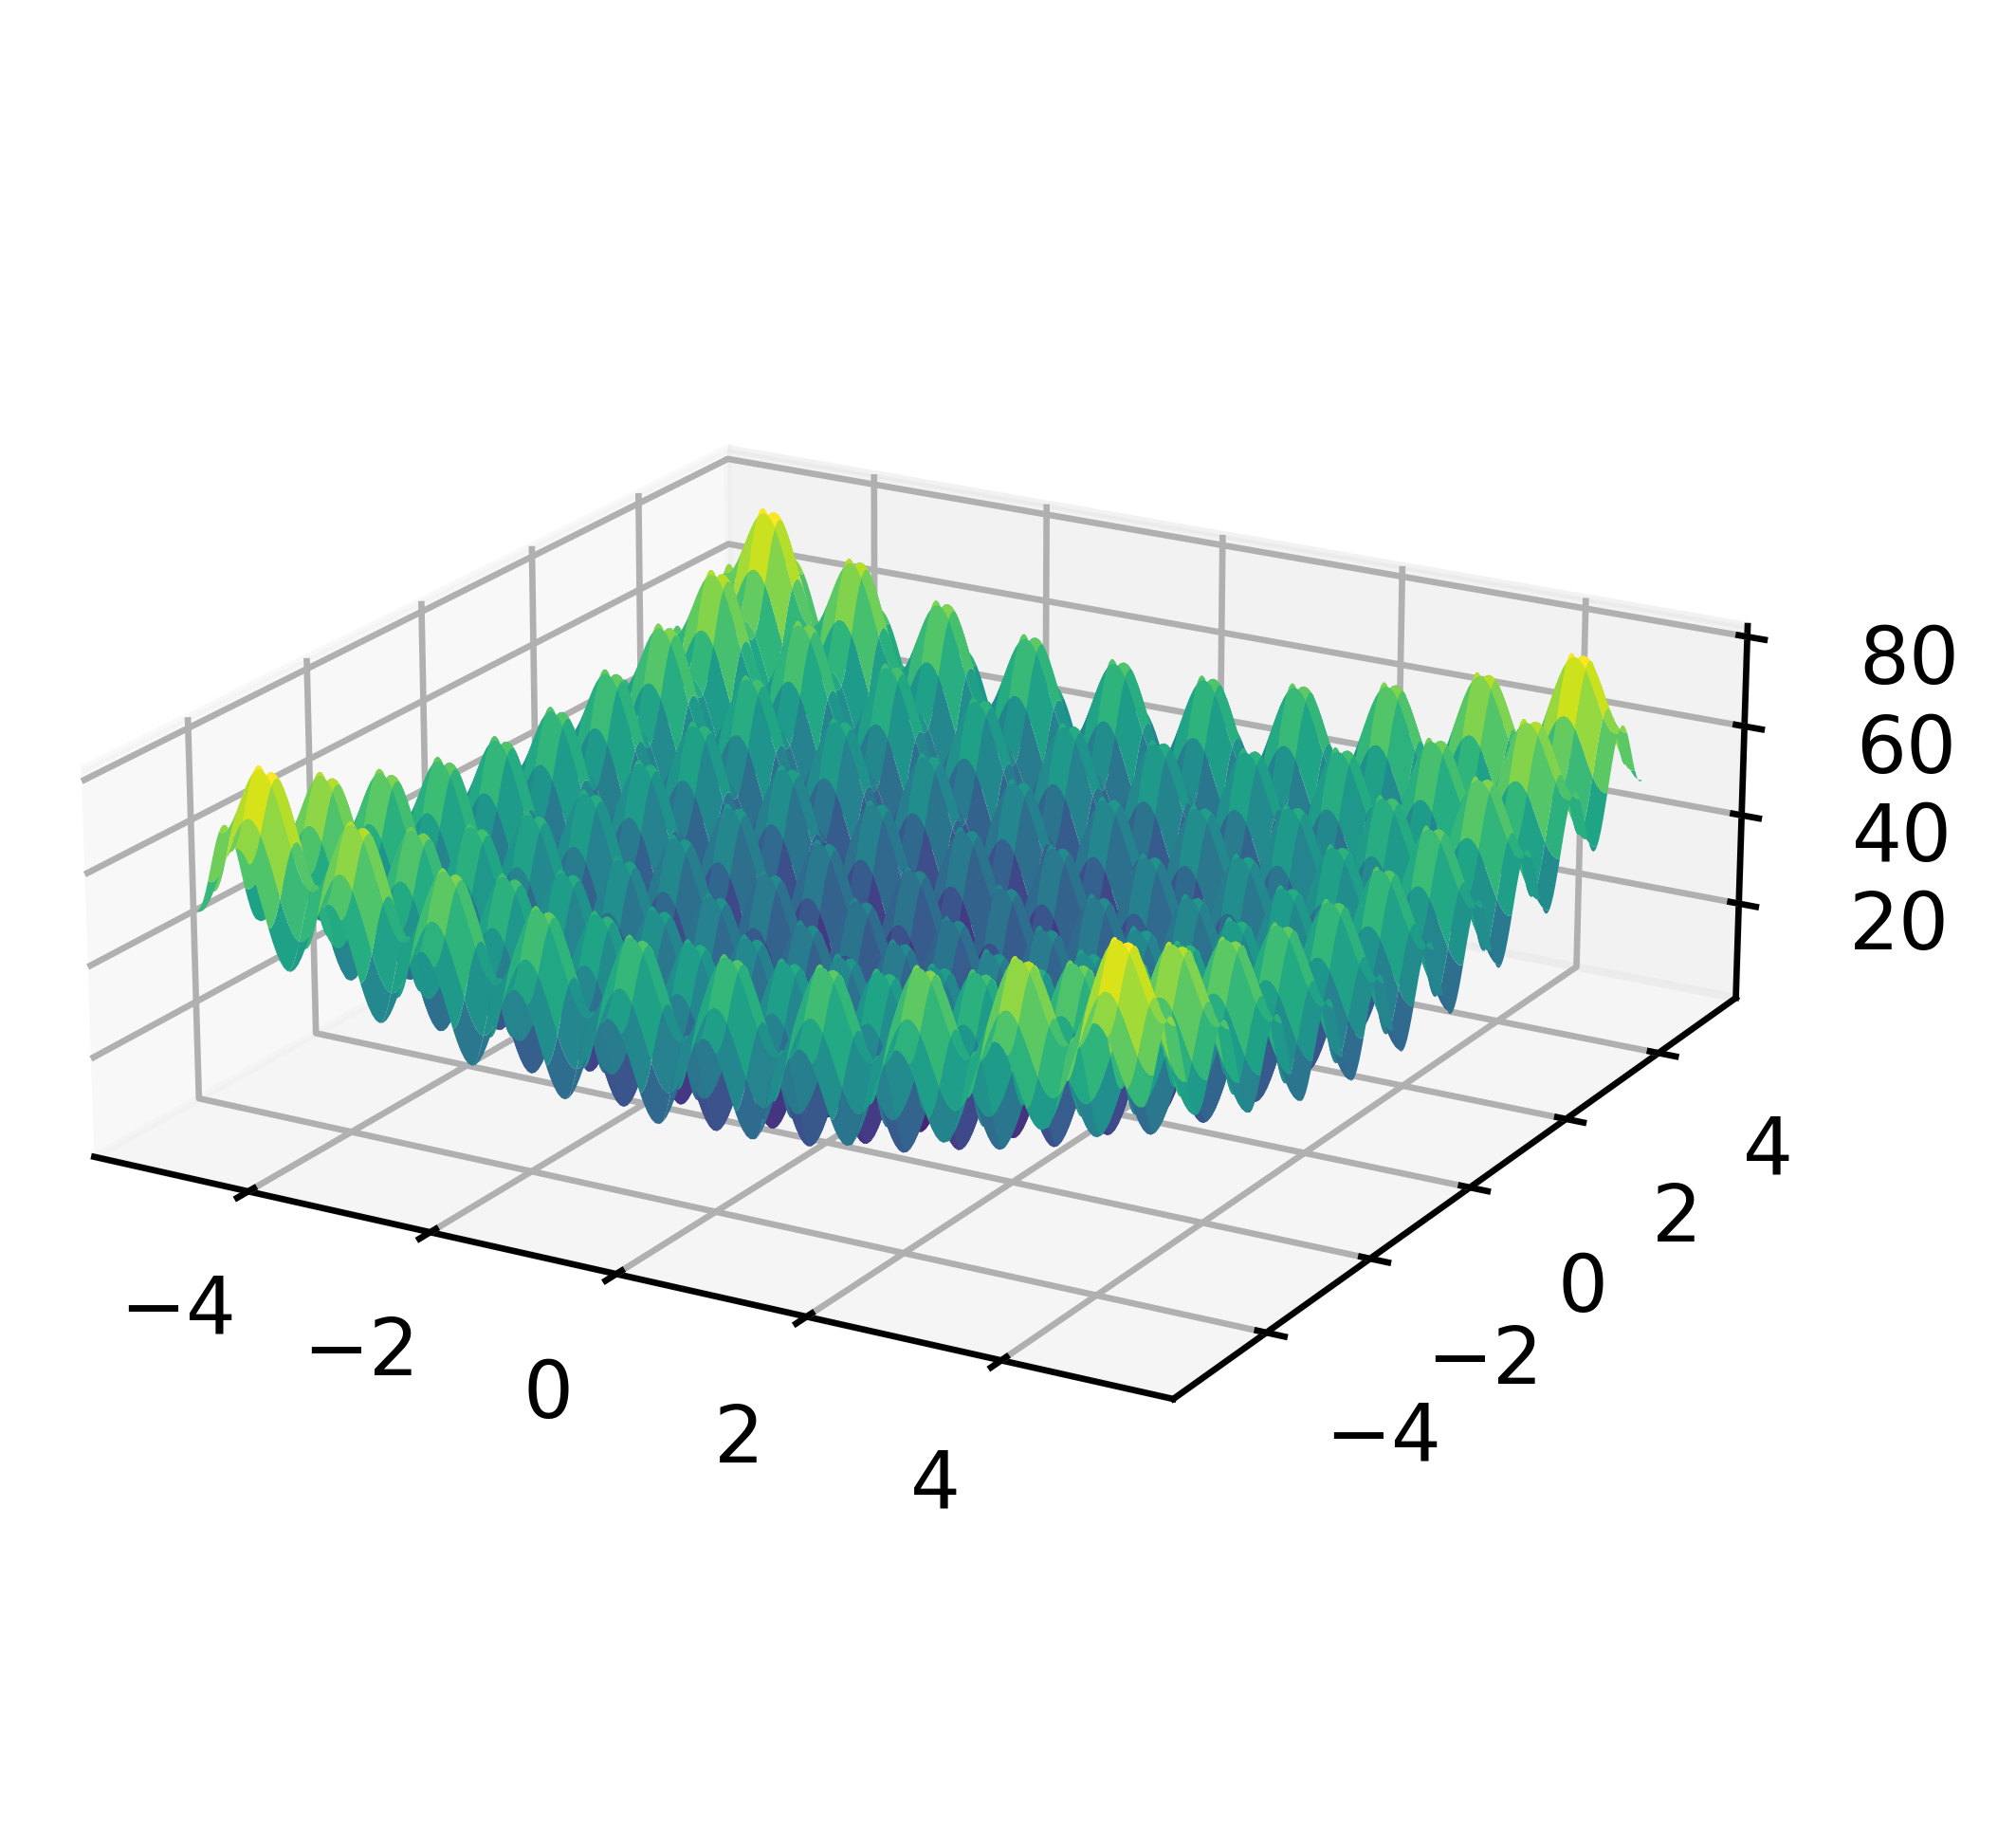

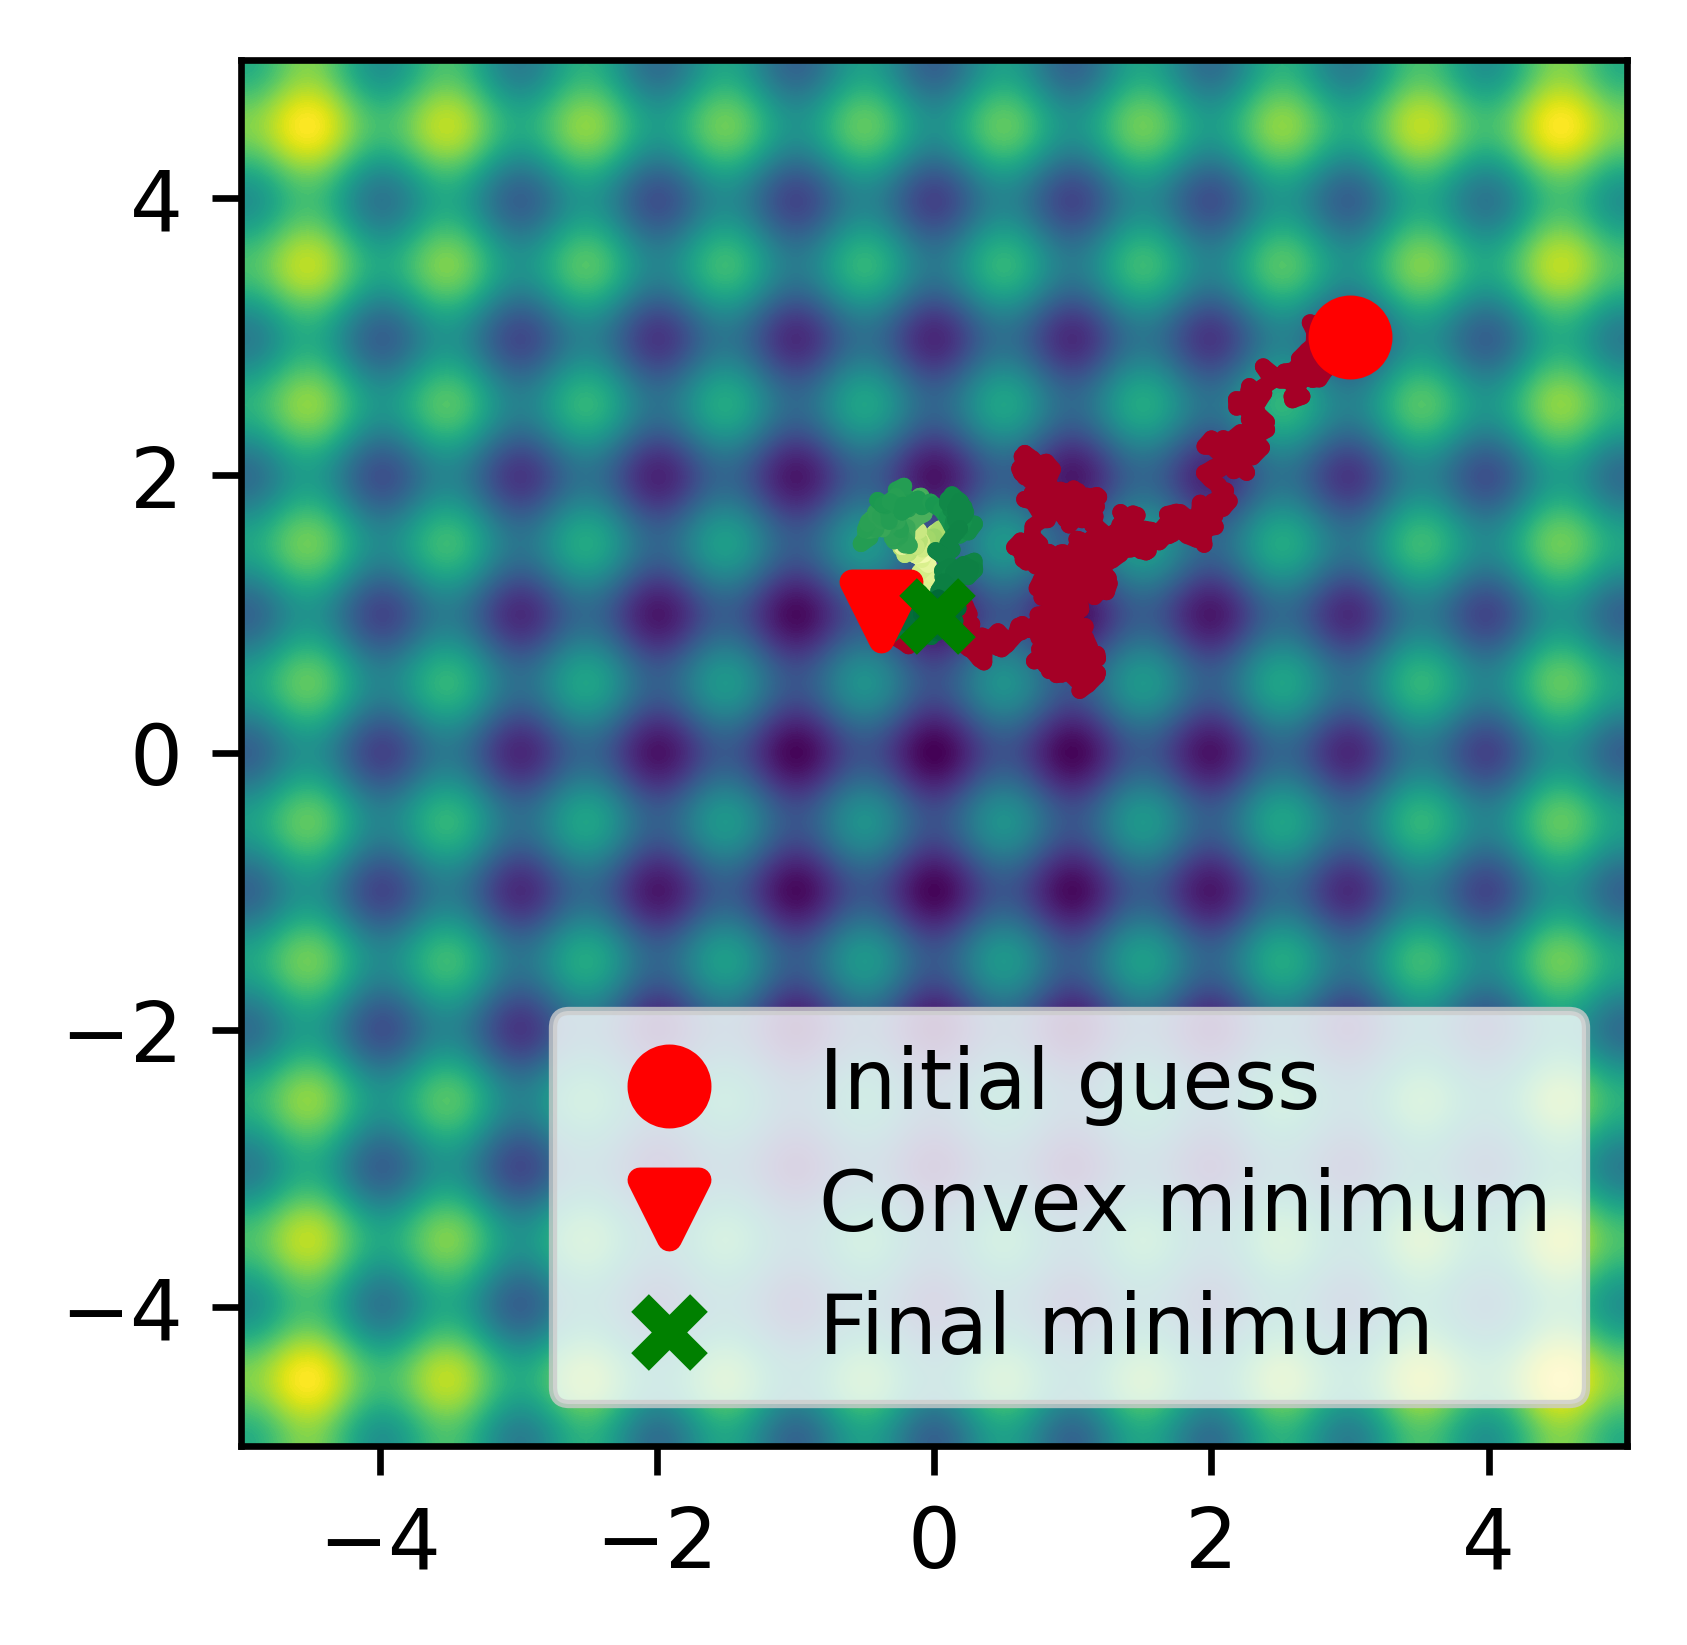

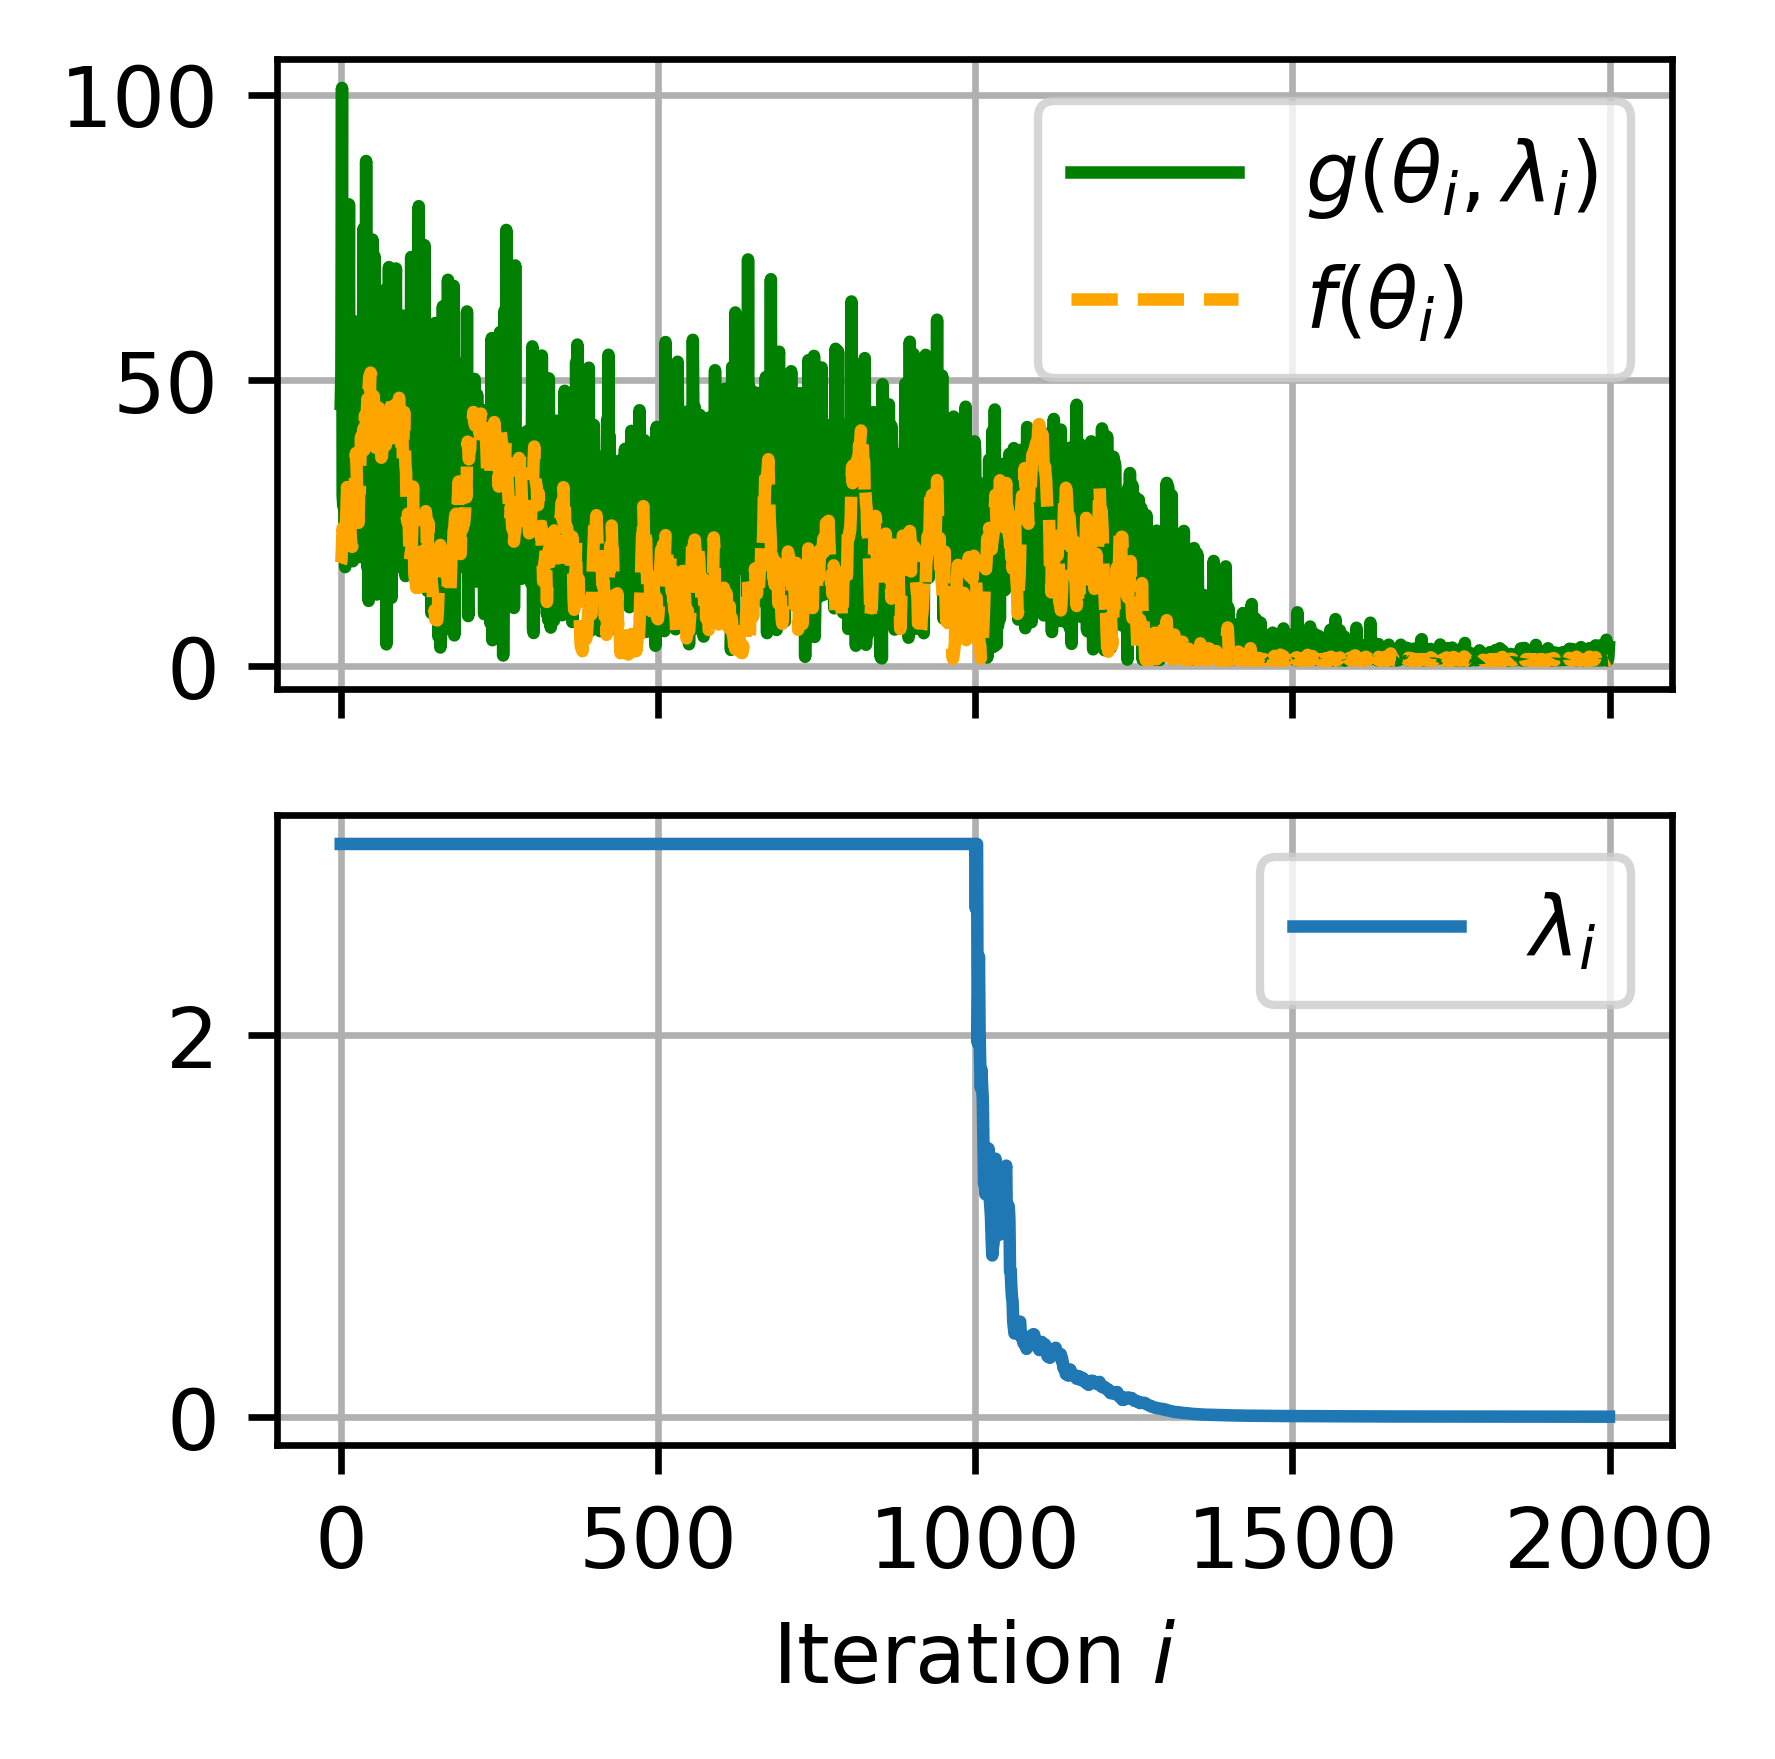

In [126]:
def main():
    f = rastrigin
    df = drastrigin
    
    theta0 = np.array([3.0, 3.0], dtype=np.float64)
    logcont0 = np.log(3)

    nwarmup = 1000
    niter = 2000
    n_mc = 1

    res = gc_opt(f, df, theta0, logcont0, nwarmup, niter, n_mc)
    print(res.theta_hist[-1])
    print(res.f_hist[-1])

    # 3d plot
    n = 250

    xl = 5
    x = np.outer(np.linspace(-xl, xl, n), np.ones(n))
    y = np.outer(np.ones(n), np.linspace(-xl, xl, n))
    z = np.zeros((n, n))

    u = np.zeros((n, n))
    v = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            z[i,j] = f(np.array([x[i,j], y[i,j]]))
            grad = df(np.array([x[i,j], y[i,j]]))
            u[i,j] = grad[0]
            v[i,j] = grad[1]
    
    fig = plt.figure(figsize=(5, 3), dpi=600)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor=None)
    ax.set_box_aspect((3,3,1))
    ax.elev = 20
    fig.tight_layout(pad=0)
    plt.show()

    # contour plot with optimization path
    fig = plt.figure(dpi=600, figsize=(3, 3))
    ax = fig.gca()
    plt.contourf(x, y, z, 100, cmap='viridis')
    #plt.quiver(x, y, u, v)
    
    points = res.theta_hist.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(-np.amax(res.cont_hist), 0)

    lc = LineCollection(segments, cmap='RdYlGn', norm=norm, path_effects=[pe.Stroke(capstyle="round")])
    lc.set_array(-res.cont_hist)
    lc.set_linewidth(2)

    ax.add_collection(lc)
    #plt.plot(res.theta_hist[:,0], res.theta_hist[:,1], 'red', linewidth=2, zorder=1)

    plt.scatter(res.theta_hist[0,0], res.theta_hist[0,1], marker="o", color="red", linewidth=3, s=50, zorder=2, label="Initial guess")
    plt.scatter(res.theta_hist[nwarmup,0], res.theta_hist[nwarmup,1], marker="v", color="red", linewidth=3, s=50, zorder=3, label="Convex minimum")
    plt.scatter(res.theta_hist[-1,0], res.theta_hist[-1,1], marker="x", color="green", linewidth=3, s=50, zorder=4, label="Final minimum")
    plt.legend(loc='lower right')
    plt.xticks([-4, -2, 0, 2, 4])
    plt.yticks([-4, -2, 0, 2, 4])
    #plt.xticks([-9, -6, -3, 0, 3, 6, 9])
    #plt.yticks([-9, -6, -3, 0, 3, 6, 9])
    ax = plt.gca()
    ax.set_aspect('equal', 'box')
    plt.show()

    # plots of f and g over optimizer step
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3, 3), dpi=600)
    ax[0].plot(range(res.niter), res.g_hist, color='green', label=r'$g(\theta_i, \lambda_i)$')
    ax[0].plot(range(res.niter), res.f_hist, color='orange', linestyle='dashed', label=r'$f(\theta_i)$')
    #ax[0].axvline(nwarmup, color='red')
    #ax[0].annotate(r' $\lambda$ begins decreasing', (nwarmup, np.amax(res.g_hist)))
    ax[0].legend(loc='upper right')
    ax[0].grid()
    ax[1].plot(range(res.niter), res.cont_hist, label=r'$\lambda_i$')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel(r'Iteration $i$')
    ax[1].grid()
    plt.show()

if __name__ == "__main__":
    main()